<a href="https://colab.research.google.com/github/sepehrkr/Deep-Learning-Course/blob/main/HW3/detect_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



برای ساخت دیتاست همه حالات تبدیل را در نظر میگیریم. هدف نهایی این است که همه لیبل ها دارای یک اندازه ورودی باشند به عبارتی بالانس باشند. همچنین حالت های تکی، دوتایی و سه تایی را نیز درنظر گرفتیم. نکته مهمی که اینجا وجود دارد این است که تبدیل های افاین جابه جا پذیر نیستند درنتیجه همه جایگشت ها را نظر میگیریم.

باید این تکه را بگوییم که مقدار دیتاست بسیار بزرگ است و روی کولب کرش میکند، درنتیجه مجبور شدم سایز دیتاست را 0.1 بکنم تا کد قابلیت اجرا داشته باشید. البته تی ای عزیز در صورت تمایل مقدار 0.1 به هر چیزی تغییر دهد(در کد واضح است)

In [ ]:
## download data
#%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
from PIL import Image

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split
import pickle
from random import randint
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
# function 1
def displacement(img):
  resize = transforms.Resize((784,784))
  tr1= transforms.CenterCrop((224,224))
  tr2 = transforms.RandomAffine(0, translate=(0.2, 0.2), fill=0)

  img = resize(img)
  img = tr2(img)
  img1 = img
  img = tr1(img)
  return img, img1

# function 2
def rotation(img):
  resize = transforms.Resize((784,784))
  tr1= transforms.CenterCrop((224,224))

  tr2 = transforms.RandomRotation(degrees=(-20,20))
  img = resize(img)
  img = tr2(img)
  img1 = img
  img = tr1(img)

  return img, img1


# function 3
def scaling(img):
  resize = transforms.Resize((784,784))
  tr1= transforms.CenterCrop((224,224))

  tr2 = transforms.RandomAffine(0,scale=(0.5,2))
  img = resize(img)
  img = tr2(img)
  img1 = img
  img = tr1(img)

  return img, img1



# function 4
def Brightness(img):  ## for augmentation
  tr2 = transforms.ColorJitter(0.1)

  img = tr2(img)

  return img



# function 5
def bluring(img):# for augmentation

  tr2 = transforms.GaussianBlur(kernel_size=3)

  img = tr2(img)


  return img

# function 6
def gaussian_noise(img):#for augmentation
  tr_tensor = transforms.ToTensor()
  tr_image = transforms.ToPILImage()
  img = tr_tensor(img)
  noise = 0.1*torch.randn(img.shape)
  img = img + noise
  img = torch.clamp(img,0,255)
  return tr_image(img.to(torch.uint8))





In [4]:
transform_dict = {0:'000',1:'100',2:'010',3:'001',4:'110',5:'101',6:'011',7:'111'}

def generate_data(root:str):
  all_transform = [[lambda img: img], # 0 transformation
                   [lambda img: displacement(img)[0]], [lambda img: rotation(img)[0]], [lambda img: scaling(img)[0]], # 1 transforamtion
                   [lambda img: displacement(rotation(img)[1])[0], lambda img: rotation(displacement(img)[1])[0]], # 2 transforamtion
                   [lambda img: displacement(scaling(img)[1])[0], lambda img: scaling(displacement(img)[1])[0]], # 2 transforamtion
                   [lambda img: rotation(scaling(img)[1])[0], lambda img: scaling(rotation(img)[1])[0]], # 2 transforamtion
                   [lambda img: displacement(rotation(scaling(img)[1])[1])[0], lambda img: displacement(scaling(rotation(img)[1])[1])[0], # 3 transforamtion
                   lambda img: rotation(displacement(scaling(img)[1])[1])[0], lambda img: scaling(displacement(rotation(img)[1])[1])[0], # 3 transforamtion
                   lambda img: scaling(rotation(displacement(img)[1])[1])[0], lambda img: rotation(scaling(displacement(img)[1])[1])[0]] # 3 transforamtion
                   ]
  augmentation = [lambda img: Brightness(img), lambda img: bluring(img)]
  #, lambda img: gaussian_noise(img)
  center_crop = transforms.CenterCrop((224,224))
  image_names = os.listdir(root)
  image_names = random.sample(image_names,k=len(image_names)//20)
  images = []
  # Augmentation
  for name in image_names:
    image = Image.open(os.path.join(root,name)).convert("RGB")
    img1 = center_crop(image)
    img2 = random.choice(augmentation)(image)
    images.extend([img1,img2])

  # Trasnformation
  dataset = []
  num_per_transform = len(images) // len(all_transform)
  idxs = np.arange(0,len(images))
  random.shuffle(idxs)

  for i in range(len(all_transform)):
    transform = all_transform[i]
    if len(transform) == 1:
      transform = transform[0]
    elif len(transform) == 2:
      transform = transform[random.choice(range(0,2))]
    else:
      transform = transform[random.choice(range(0,6))]

    for j in range(i*num_per_transform, (i+1)*num_per_transform):
      dataset.append((images[idxs[j]],transform(images[idxs[j]]),i))

  return dataset



class CustomDataset(Dataset):

    def __init__(self, dataset):
      super().__init__()

      self.dataset = dataset
      self.transform = transforms.Compose([transforms.CenterCrop((224,224)),transforms.ToTensor()])

    def __getitem__(self,idx):
      org_image, image, label = self.dataset[idx]
      org_image = self.transform(org_image)
      image = self.transform(image)
      return (org_image, image, label)
    def __len__(self):
      return len(self.dataset)


In [5]:
train_data = generate_data('/content/ADEChallengeData2016/images/training')
val_data = generate_data('/content/ADEChallengeData2016/images/validation')
test_data = generate_data('/content/release_test/testing')


dataset_train = CustomDataset(train_data)## To Do
dataset_test = CustomDataset(test_data)## To Do
dataset_val = CustomDataset(val_data)## To Do


train_loader = DataLoader(dataset_train,batch_size=32,shuffle=True)## To Do
test_loader= DataLoader(dataset_test,batch_size=32,shuffle=True)## To Do
val_loader = DataLoader(dataset_val,batch_size=32,shuffle=True)## To Do


Train Images ....
101


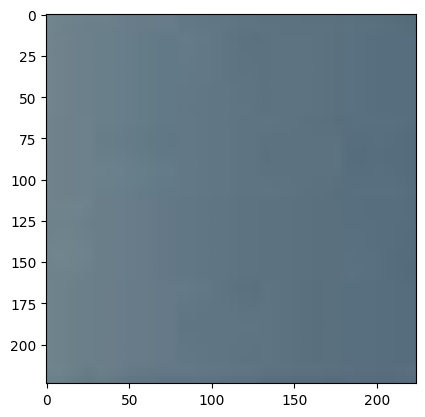

110


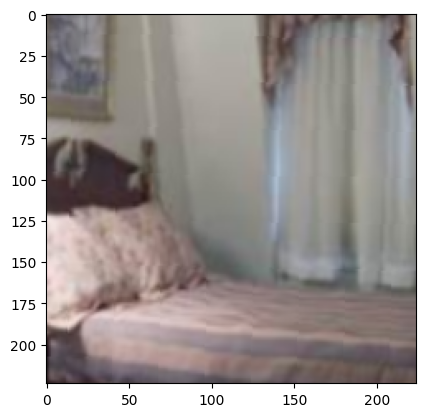

011


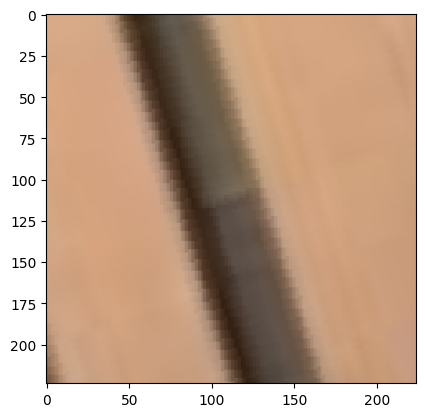

101


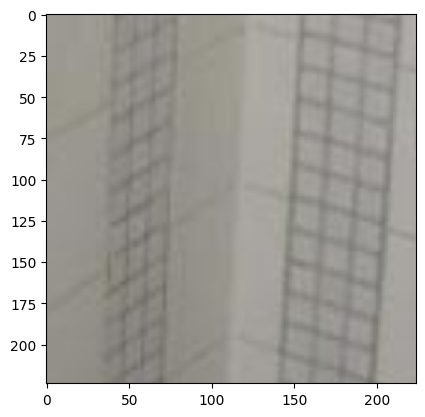

000


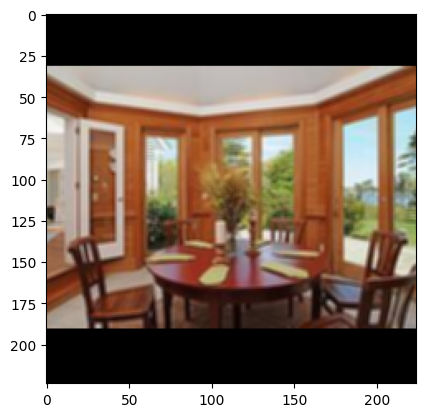

100


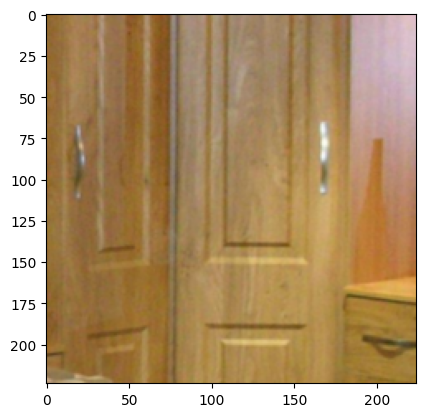

001


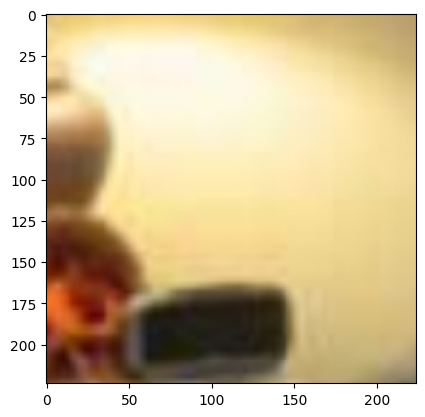

001


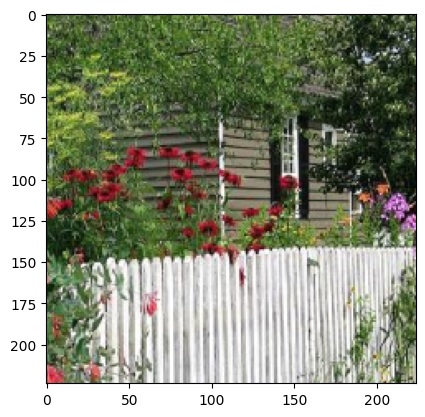

Test Images ....
011


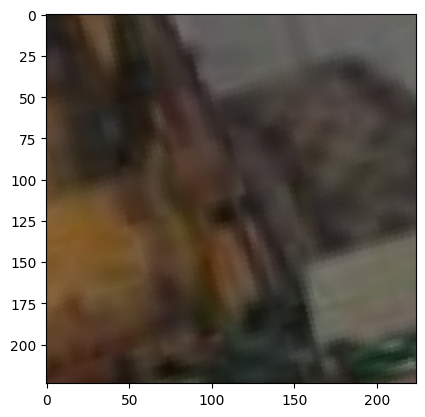

000


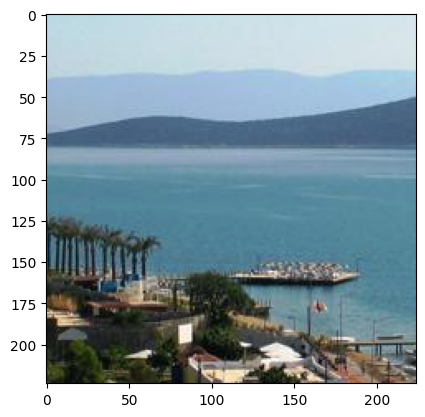

001


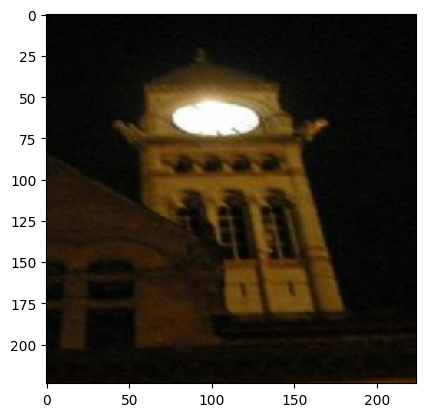

011


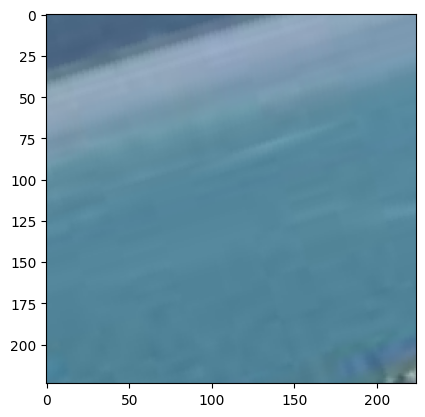

011


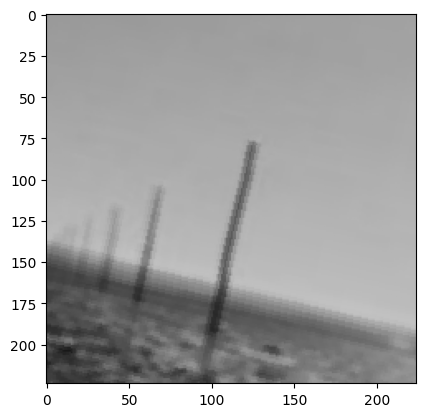

010


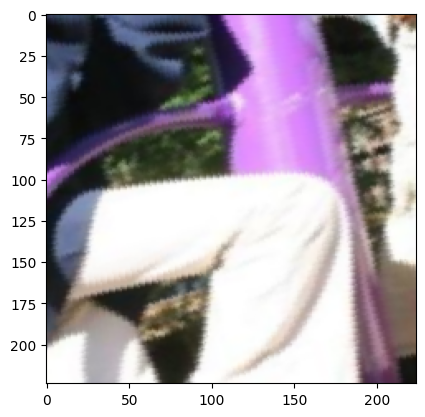

001


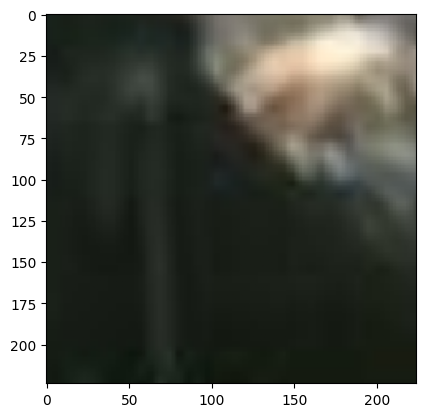

111


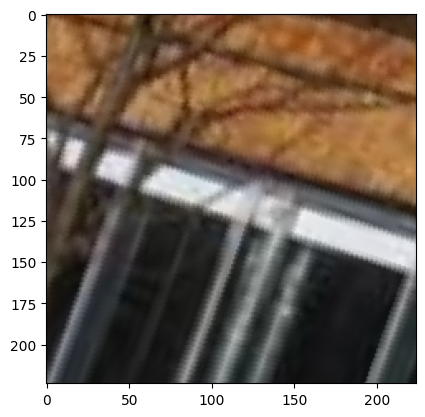

In [6]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
print('Train Images ....')
_,images, targets = next(iter(train_loader))
idxs = random.sample(range(0,32),k=8)
for idx in idxs:
  print(transform_dict[targets[idx].item()])
  plt.figure()
  plt.imshow(images[idx].permute(1,2,0))
  plt.show()

print('Test Images ....')
_,images, targets = next(iter(test_loader))
idxs = random.sample(range(0,32),k=8)
for idx in idxs:
  print(transform_dict[targets[idx].item()])
  plt.figure()
  plt.imshow(images[idx].permute(1,2,0))
  plt.show()


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

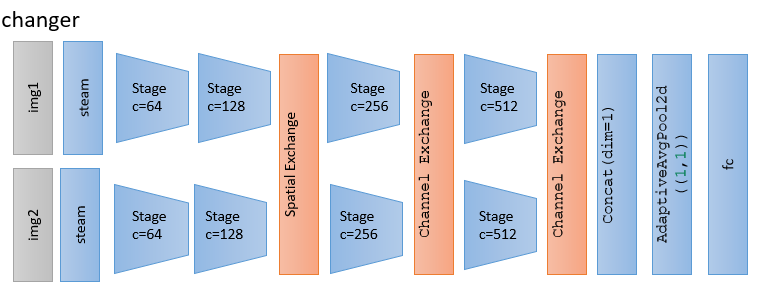

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


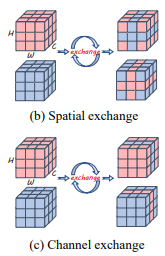

In [7]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

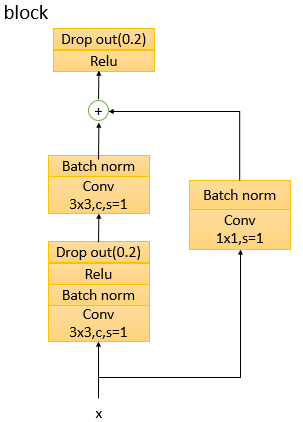

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





مقدار اندازه ورودی و خروجی را به کلاس میدهیم با این کار راحتتر و بهینه تر میتوان مدل را پیاده سازی کرد.
در کانولوشن یه بعدی مقدار پدینگ صفر است. دلیل استفاده از آن هم هم طول کردن کانال های دو متغیر می باشد.
مقدار خروجی این کانولوشن برابر با خروجی بلوک است.

مقدار پدینگ برای دو کانو دیگر بربار با 1 است همچنین خروجی دومی برابر با خروجی بلوک است.
و خروجی اول همان ورودی اش است

In [8]:
##To Do
class block(nn.Module):
  def __init__(self,in_channels, out_channels):
    super(block,self).__init__()
    self.conv1 = nn.Conv2d(in_channels,in_channels,(3,3),1,1)
    self.conv2 = nn.Conv2d(in_channels,out_channels,(1,1),1)
    self.conv3 = nn.Conv2d(in_channels,out_channels,(3,3),1,1)
    self.batch1 = nn.BatchNorm2d(in_channels)
    self.batch2 = nn.BatchNorm2d(out_channels)
    self.batch3 = nn.BatchNorm2d(out_channels)
    self.drop1 = nn.Dropout2d(0.2)
    self.drop2 = nn.Dropout2d(0.2)
    self.relu = nn.ReLU()
  def forward(self,x):
    x1 = x
    x1 = self.conv1(x1)
    x1 = self.batch1(x1)
    x1 = self.relu(x1)
    x1 = self.drop1(x1)
    x1 = self.conv3(x1)
    x1 = self.batch3(x1)
    x = self.conv2(x)
    x = self.batch2(x)
    x = x1 + x
    x = self.relu(x)
    x = self.drop2(x)

    return x

In [140]:
model = block(3,64)
x = torch.rand(32,3,224,224)
y = model(x)

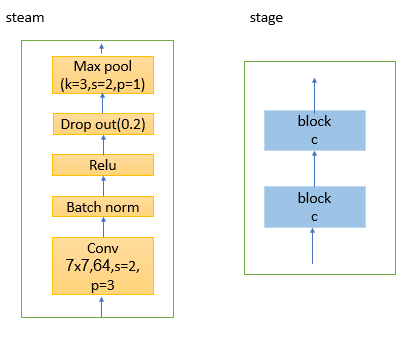

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [12]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
        nn.Conv2d(3,64,7,2,3),nn.BatchNorm2d(64),nn.ReLU(),nn.Dropout2d(0.2),nn.MaxPool2d(3,2,1)
        )

    self.stage1= self._make_stage(64,64)
    self.stage2= self._make_stage(64,128)
    self.stage3= self._make_stage(128,256)
    self.stage4= self._make_stage(256,512)

    self.spatial = SpatialExchange()
    self.channel1 = ChannelExchange()
    self.channel2  = ChannelExchange()

    self.aap = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(1024,8)

  def _make_stage(self,in_channels, out_channels):

    layers=[block(in_channels,out_channels),block(out_channels,out_channels)]

    return nn.Sequential(*layers)




  def forward(self,x1,x2):
    x1 = self.steam(x1)
    x2 = self.steam(x2)
    x1 = self.stage1(x1)
    x2 = self.stage1(x2)

    x1 = self.stage2(x1)
    x2 = self.stage2(x2)

    x1, x2 = self.spatial(x1,x2)

    x1 = self.stage3(x1)
    x2 = self.stage3(x2)

    x1, x2 = self.channel1(x1,x2)

    x1 = self.stage4(x1)
    x2 = self.stage4(x2)

    x1, x2 = self.channel2(x1,x2)

    out = torch.concat((x1,x2),dim=1)
    out = self.aap(out)
    out = self.fc(out.flatten(1))

    return out

In [13]:
## To Do
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model=changer(block,SpatialExchange,ChannelExchange).to(device)

citeration = nn.CrossEntropyLoss().to(device) ## loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)## optimizer

##Train & validation


In [16]:
Loss_train=[]
Loss_val=[]
batch_size = 32
num_epochs = 20
accuracies = []
len_trainLoader = len(train_loader)
for epoch in range(num_epochs):
  model.train()
  current_loss = 0.0
  accuracy = 0.0
  tqdm_bar = tqdm(train_loader, desc=f'Training Epoch {epoch} ', total=int(len_trainLoader))
  for i,(x1, x2, targets) in enumerate(tqdm_bar):
    x1 = x1.to(device)
    x2 = x2.to(device)
    targets = targets.to(device)
    labels = model(x1,x2)
    optimizer.zero_grad()
    loss = citeration(labels,targets)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()/batch_size # to prevent overflow.

  current_loss /= len_trainLoader
  Loss_train.append(current_loss)
  accuracy = accuracy*batch_size/len(dataset_train)
  accuracies.append(accuracy)
  print(f"Loss: {current_loss}, Accuracy: {accuracy}")
  torch.save(model.state_dict(), '/content/drive/MyDrive/transformation_model.pth')



Training Epoch 0 : 100%|██████████| 63/63 [01:35<00:00,  1.52s/it]


Loss: 2.118967754500253, Accuracy: 0.1284722238779068


Training Epoch 1 : 100%|██████████| 63/63 [01:38<00:00,  1.56s/it]


Loss: 2.0820902415684293, Accuracy: 0.1711309552192688


Training Epoch 2 : 100%|██████████| 63/63 [01:39<00:00,  1.59s/it]


Loss: 1.9656077736899966, Accuracy: 0.2063492238521576


Training Epoch 3 : 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


Loss: 1.8286146171509274, Accuracy: 0.2296627163887024


Training Epoch 4 : 100%|██████████| 63/63 [01:40<00:00,  1.60s/it]


Loss: 1.78633133191911, Accuracy: 0.2495039850473404


Training Epoch 5 : 100%|██████████| 63/63 [01:40<00:00,  1.60s/it]


Loss: 1.753301461537679, Accuracy: 0.2519841492176056


Training Epoch 6 : 100%|██████████| 63/63 [01:41<00:00,  1.61s/it]


Loss: 1.7497194854039995, Accuracy: 0.2430555671453476


Training Epoch 7 : 100%|██████████| 63/63 [01:40<00:00,  1.60s/it]


Loss: 1.7411379889836387, Accuracy: 0.2514881193637848


Training Epoch 8 : 100%|██████████| 63/63 [01:42<00:00,  1.63s/it]


Loss: 1.752540739755782, Accuracy: 0.2435515969991684


Training Epoch 9 : 100%|██████████| 63/63 [01:42<00:00,  1.63s/it]


Loss: 1.7293407841334267, Accuracy: 0.250992089509964


Training Epoch 10 : 100%|██████████| 63/63 [01:41<00:00,  1.61s/it]


Loss: 1.7346328648309859, Accuracy: 0.2579365372657776


Training Epoch 11 : 100%|██████████| 63/63 [01:42<00:00,  1.63s/it]


Loss: 1.724853545900375, Accuracy: 0.2549603283405304


Training Epoch 12 : 100%|██████████| 63/63 [01:41<00:00,  1.61s/it]


Loss: 1.7215186149354964, Accuracy: 0.2519841492176056


Training Epoch 13 : 100%|██████████| 63/63 [01:43<00:00,  1.64s/it]


Loss: 1.7157458029096089, Accuracy: 0.2624008059501648


Training Epoch 14 : 100%|██████████| 63/63 [01:41<00:00,  1.62s/it]


Loss: 1.7249550308500017, Accuracy: 0.2529762089252472


Training Epoch 15 : 100%|██████████| 63/63 [01:41<00:00,  1.61s/it]


Loss: 1.7128258716492426, Accuracy: 0.2663690745830536


Training Epoch 16 : 100%|██████████| 63/63 [01:41<00:00,  1.61s/it]


Loss: 1.7165768468190754, Accuracy: 0.2599206566810608


Training Epoch 17 : 100%|██████████| 63/63 [01:41<00:00,  1.60s/it]


Loss: 1.707069442385719, Accuracy: 0.2624008059501648


Training Epoch 18 : 100%|██████████| 63/63 [01:41<00:00,  1.60s/it]


Loss: 1.6997646717798143, Accuracy: 0.2852182686328888


Training Epoch 19 : 100%|██████████| 63/63 [01:41<00:00,  1.60s/it]

Loss: 1.709373703078618, Accuracy: 0.276289701461792


In [20]:
torch.save({'model_state_dict':model.state_dict(),'optimizer_state_dict':optimizer.state_dict(),'epoch':epoch,'loss':Loss_train[-1]},'/content/drive/MyDrive/Transformation_Model.pth')

model.eval()
val_accuracy = 0.0
val_loss = 0.0
train_loss = 0.0
train_accuracy = 0.0
with torch.no_grad():
  for i,(x1,x2, targets) in enumerate(val_loader):
    x1 = x1.to(device)
    x2 = x2.to(device)
    targets = targets.to(device)
    labels = model(x1,x2)
    loss = citeration(labels,targets)
    val_loss += loss.item()
    _, prediction = torch.max(labels,dim=1)
    val_accuracy += (prediction==targets).sum()

  val_accuracy /= len(dataset_val)
  val_loss /= len(val_loader)

  for i,(x1,x2, targets) in enumerate(train_loader):
    x1 = x1.to(device)
    x2 = x2.to(device)
    targets = targets.to(device)
    labels = model(x1,x2)
    loss = citeration(labels,targets)
    train_loss += loss.item()
    _, prediction = torch.max(labels,dim=1)
    train_accuracy += (prediction==targets).sum()

  train_accuracy /= len(dataset_train)
  train_loss /= len(train_loader)




print(f'loss_TRAIN ={train_loss:.3f},acc_train={(train_accuracy)},\t loss_val= {val_loss:.3f}, acc_val={(val_accuracy)}')

loss_TRAIN =1.696,acc_train=0.2837301790714264,	 loss_val= 1.743, acc_val=0.26499998569488525


#Test


In [39]:
checkpoint = torch.load('/content/drive/MyDrive/Transformation_Model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test
model.eval()
test_loss = 0.0
test_accuracy = 0.0
cat_acc = {'000':0,'100':0,'010':0,'001':0,'110':0,'101':0,'011':0,'111':0}
length = len(dataset_train) // 8
with torch.no_grad():
  for i,(x1,x2, targets) in enumerate(test_loader):
    x1 = x1.to(device)
    x2 = x2.to(device)
    targets = targets.to(device)
    labels = model(x1,x2)
    loss = citeration(labels,targets)
    test_loss += loss.item()
    _, prediction = torch.max(labels,dim=1)
    idxs = prediction[prediction==targets]
    for idx in idxs:
      cat_acc[transform_dict[idx.item()]] += 1
    test_accuracy += (prediction==targets).sum()
  test_accuracy /= len(dataset_test)
  test_loss /= len(test_loader)

print(f' loss_test= {test_loss:.3f}, acc_test={(test_accuracy)}')

 loss_test= 1.731, acc_test=0.2835365831851959


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

In [41]:
print(cat_acc)

{'000': 41, '100': 2, '010': 0, '001': 22, '110': 28, '101': 0, '011': 0, '111': 0}


مشاهد میکنیم که عکس های با یک تغییر بهتر از عکس های با دو تغییر و آن هم بهتر از عکس های با سه تغییر تشخیص داده میشوند.